In [3]:
# ============================================================
# 02.Análisis Exploratorio de Datos Espaciales (ESDA) - Cerrillos
# ============================================================

# 1. Importar librerías
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

import libpysal
from esda import Moran, Moran_Local
from esda.getisord import G_Local
import matplotlib.colors as mcolors
from skgstat import Variogram
import numpy as np

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

 Datos cargados para ESDA
Edificios en Cerrillos: 4016


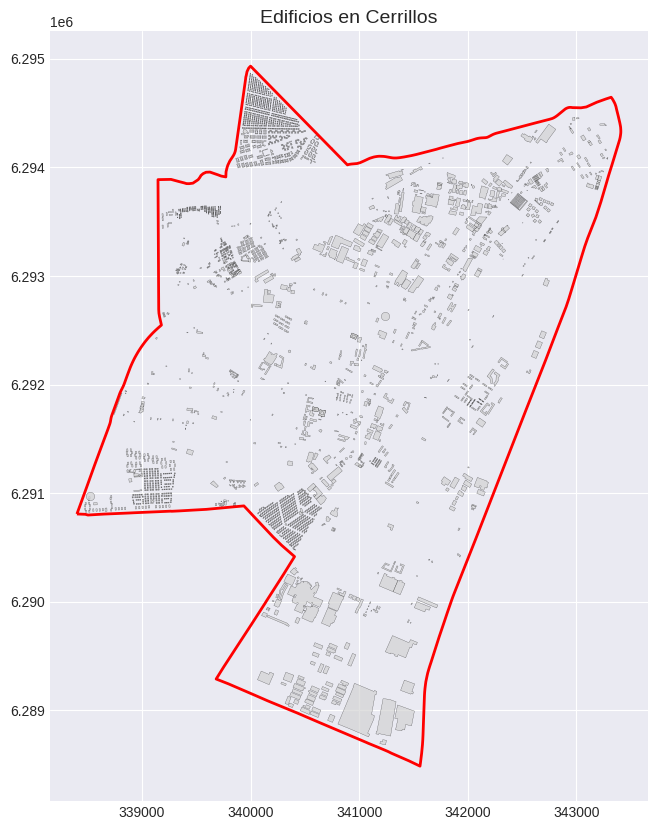

In [4]:
# ============================================================
# 2. Cargar datasets
# ============================================================
RAW_DIR = "../data/raw"

cerrillos = gpd.read_file(f"{RAW_DIR}/cerrillos_limite.shp").to_crs(epsg=32719)
buildings = gpd.read_file(f"{RAW_DIR}/osm_buildings_cerrillos.geojson").to_crs(epsg=32719)

# Calcular área de cada edificio
buildings["area_m2"] = buildings.geometry.area

print(" Datos cargados para ESDA")
print(f"Edificios en Cerrillos: {len(buildings)}")

# Visualización básica
fig, ax = plt.subplots(figsize=(10, 10))
cerrillos.boundary.plot(ax=ax, color="red", linewidth=2)
buildings.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.2, alpha=0.7)
ax.set_title("Edificios en Cerrillos", fontsize=14)
plt.show()


In [5]:
# ============================================================
# 3. Autocorrelación Espacial (Moran’s I Global)
# ============================================================
w = libpysal.weights.Queen.from_dataframe(buildings)
w.transform = "r"

moran = Moran(buildings["area_m2"], w)

print("\n Autocorrelación Espacial Global (Moran’s I)")
print(f"I = {moran.I:.3f}")
print(f"p-value = {moran.p_sim:.4f}")


 Autocorrelación Espacial Global (Moran’s I)
I = 0.247
p-value = 0.0010


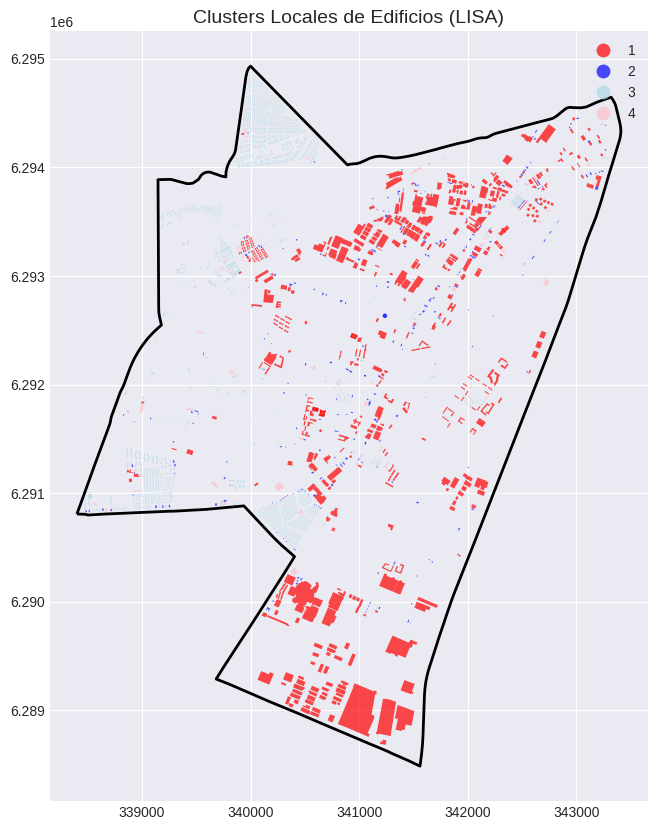

In [6]:
# ============================================================
# 4. Clusters Locales (LISA)
# ============================================================
lisa = Moran_Local(buildings["area_m2"], w)
buildings["lisa_cluster"] = lisa.q
buildings["lisa_pvalue"] = lisa.p_sim

cluster_colors = {
    1: "red",      # Alto-Alto
    2: "blue",     # Bajo-Bajo
    3: "lightblue",# Bajo-Alto
    4: "pink"      # Alto-Bajo
}

fig, ax = plt.subplots(figsize=(10, 10))
cerrillos.boundary.plot(ax=ax, color="black", linewidth=2)
buildings.plot(
    ax=ax,
    column="lisa_cluster",
    categorical=True,
    cmap=mcolors.ListedColormap([cluster_colors[k] for k in sorted(cluster_colors.keys())]),
    legend=True,
    markersize=5,
    alpha=0.7
)
ax.set_title("Clusters Locales de Edificios (LISA)", fontsize=14)
plt.show()

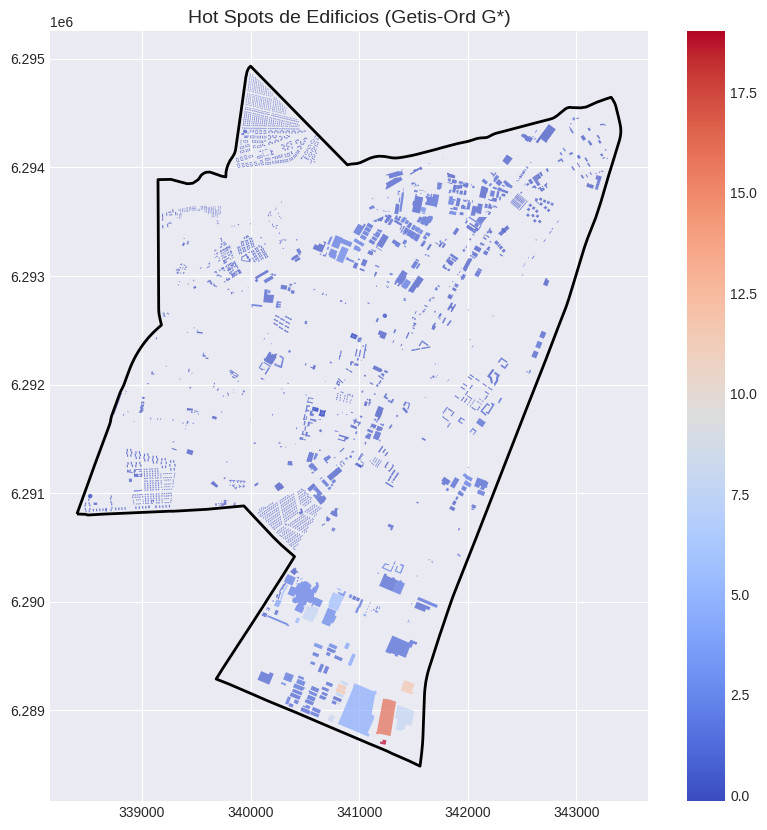

In [7]:
# ============================================================
# 5. Hot Spots (Getis-Ord G*)
# ============================================================
g = G_Local(buildings["area_m2"], w)
buildings["GiZScore"] = g.Zs
buildings["GiPValue"] = g.p_sim

fig, ax = plt.subplots(figsize=(10, 10))
cerrillos.boundary.plot(ax=ax, color="black", linewidth=2)
buildings.plot(
    ax=ax,
    column="GiZScore",
    cmap="coolwarm",
    legend=True,
    alpha=0.7,
    markersize=5
)
ax.set_title("Hot Spots de Edificios (Getis-Ord G*)", fontsize=14)
plt.show()

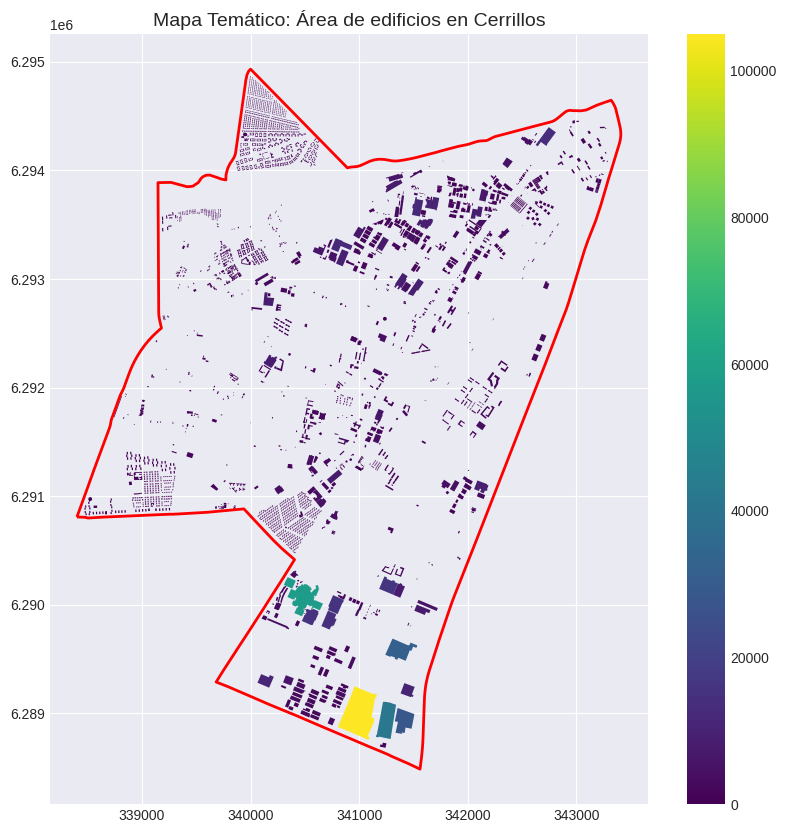

In [8]:

# ============================================================
# 6. Visualización temática: Área de edificios
# ============================================================
fig, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="area_m2",
    cmap="viridis",
    legend=True,
    markersize=3
)
cerrillos.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("Mapa Temático: Área de edificios en Cerrillos", fontsize=14)
plt.show()


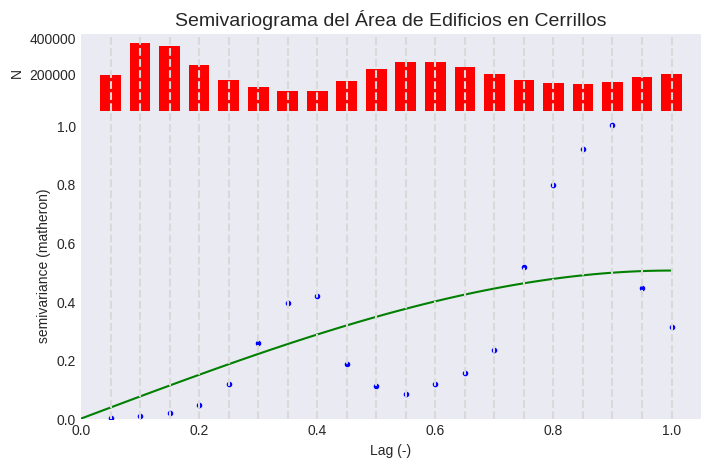

In [9]:

# ============================================================
# 7. Análisis Geoestadístico (Semivariograma)
# ============================================================
buildings["centroid"] = buildings.geometry.centroid
coords = np.array(list(zip(buildings.centroid.x, buildings.centroid.y)))
values = buildings["area_m2"].values

V = Variogram(coords, values, normalize=True, n_lags=20, maxlag="median")

fig = V.plot()
plt.title("Semivariograma del Área de Edificios en Cerrillos", fontsize=14)
plt.show()


✅ Imágenes y datos de ESDA guardados correctamente en outputs/reports/


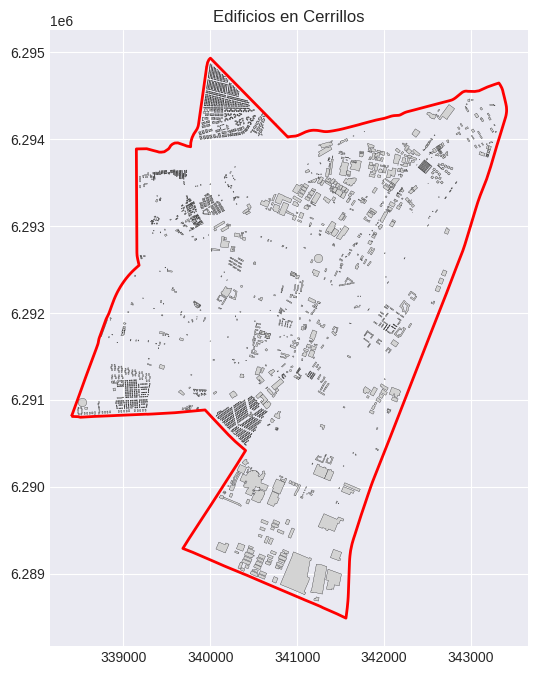

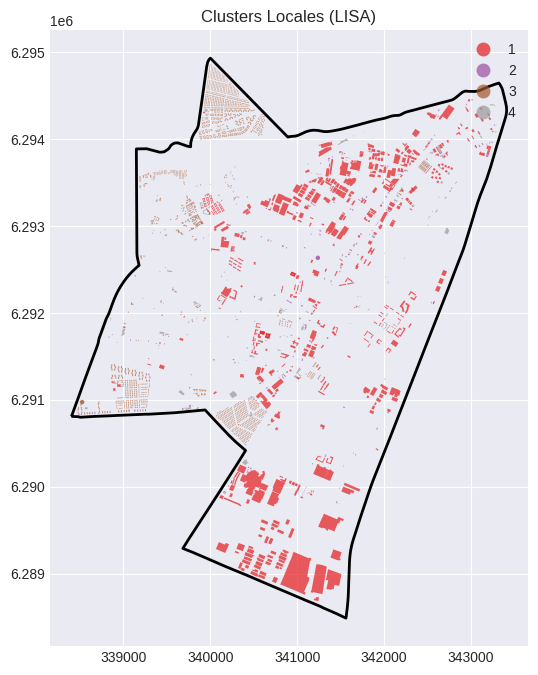

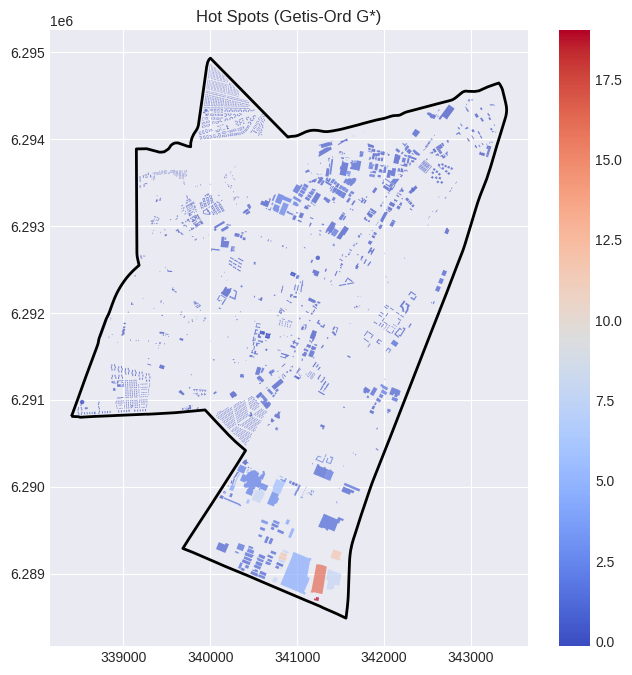

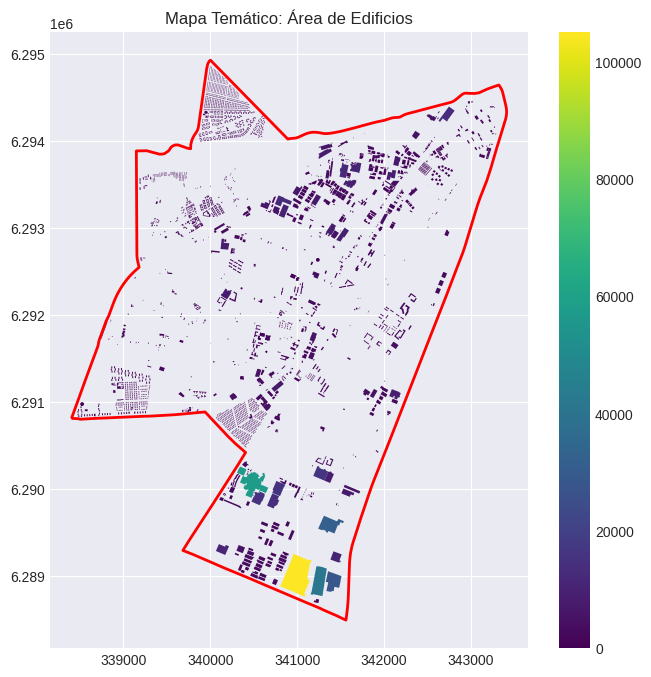

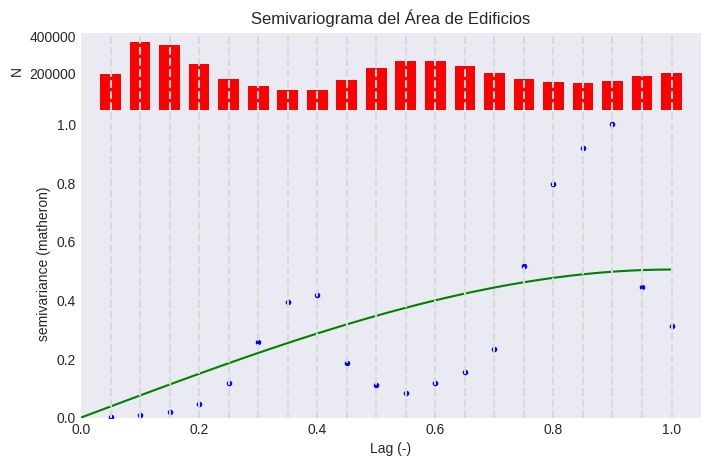

In [12]:
# ============================================================
# 🔹 GUARDAR RESULTADOS Y GRÁFICOS DEL ANÁLISIS EXPLORATORIO
# ============================================================

from pathlib import Path
import matplotlib.pyplot as plt

# Crear carpeta de salida si no existe
OUTPUT_DIR = Path("../outputs/reports")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1. Guardar dataset procesado (con áreas y clusters) ---
if "centroid" in buildings.columns:
    buildings = buildings.drop(columns=["centroid"])
buildings.to_file(OUTPUT_DIR / "cerrillos_esda.geojson", driver="GeoJSON")

# --- 2. Guardar gráficos individuales ---
# (Se asume que ya generaste cada figura antes de este bloque)

# Mapa base de edificios
fig, ax = plt.subplots(figsize=(8,8))
cerrillos.boundary.plot(ax=ax, color="red", linewidth=2)
buildings.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.2)
plt.title("Edificios en Cerrillos")
plt.savefig(OUTPUT_DIR / "esda_mapa_base.png", dpi=300, bbox_inches="tight")

# Clusters LISA
fig, ax = plt.subplots(figsize=(8,8))
cerrillos.boundary.plot(ax=ax, color="black", linewidth=2)
buildings.plot(
    ax=ax,
    column="lisa_cluster",
    categorical=True,
    cmap="Set1",
    legend=True,
    markersize=5,
    alpha=0.7
)
plt.title("Clusters Locales (LISA)")
plt.savefig(OUTPUT_DIR / "esda_clusters_lisa.png", dpi=300, bbox_inches="tight")

# Hotspots (Getis-Ord G*)
fig, ax = plt.subplots(figsize=(8,8))
cerrillos.boundary.plot(ax=ax, color="black", linewidth=2)
buildings.plot(
    ax=ax,
    column="GiZScore",
    cmap="coolwarm",
    legend=True,
    markersize=5,
    alpha=0.7
)
plt.title("Hot Spots (Getis-Ord G*)")
plt.savefig(OUTPUT_DIR / "esda_hotspots.png", dpi=300, bbox_inches="tight")

# Mapa temático de áreas
fig, ax = plt.subplots(figsize=(8,8))
cerrillos.boundary.plot(ax=ax, color="red", linewidth=2)
buildings.plot(ax=ax, column="area_m2", cmap="viridis", legend=True, markersize=3)
plt.title("Mapa Temático: Área de Edificios")
plt.savefig(OUTPUT_DIR / "esda_area_tematica.png", dpi=300, bbox_inches="tight")

# Semivariograma
fig = V.plot()
plt.title("Semivariograma del Área de Edificios")
plt.savefig(OUTPUT_DIR / "esda_semivariograma.png", dpi=300, bbox_inches="tight")

print("✅ Imágenes y datos de ESDA guardados correctamente en outputs/reports/")
